## Initial setup

In [1]:
import importlib # Used to add reload functionality, for when we update our own custom libraries
import re
from typing import List
import ollama
import pandas as pd
import json
import os

# Custom libraries
import brikasutils as bu
importlib.reload(bu)
import shared_utils as utils
from shared_utils import systemMsg, userMsg, assistantMsg, find_most_similar
importlib.reload(utils)

<module 'shared_utils' from '/Users/e/Documents/GitHub/Thesis/shared_utils.py'>

## Persona

In [2]:
import re

# Custom libraries
import standard_msg_reader as fb
importlib.reload(fb)
import persona
importlib.reload(persona)


<module 'persona' from '/Users/e/Documents/GitHub/Thesis/persona.py'>

In [4]:
texts_with_elias = [
    "selected-data/elias/message_1.json",
]
texts_with_petyo = [
    "selected-data/petyo/message_1.json",
    "selected-data/petyo/message_2.json",
    "selected-data/petyo/message_3.json",
    "selected-data/petyo/message_4.json",
    "selected-data/petyo/message_5.json",
]
texts_with_others_dict = {
    "anna": ["selected-data/others/anna.json"],
    "patryk": ["selected-data/others/patryk.json"],
    "andreas": ["selected-data/others/andreas.json"],
    "victoria": ["selected-data/others/victoria.json", "selected-data/others/victoria2.json"],
    "joanna": ["selected-data/others/joanna.json"],
    "antoni": ["selected-data/others/antoni.json"],
    "arijan": ["selected-data/others/arijan.json"],
    "denis": ["selected-data/others/denis.json"],
    "alexandra": ["selected-data/others/alexandra.json"],
    "FED": ["selected-data/others/FED.json"],
    "filip": ["selected-data/others/filip.json"],
    "kuba": ["selected-data/others/kuba.json"],
    "laura": ["selected-data/others/laura.json"],
    "liisa": ["selected-data/others/liisa.json"],
    "luiza": ["selected-data/others/luiza.json"],
    "marcus": ["selected-data/others/marcus.json"],
}


ab = persona.PersonaEncoder()
ab.parse_fb_messages(texts_with_elias, "elias")
ab.parse_fb_messages(texts_with_petyo, "petyo")
for name, texts in texts_with_others_dict.items():
    ab.parse_fb_messages(texts, name)

ab.parse_rosebud_entries("selected-data/rosebud.md", "rosebud")
ab.filter_chats_empty()
ab.filter_chats_regex(utils.BLACKLIST_CHAT_REGEX_FILTERS)


for nameid, chat in ab.chats.items():
    for msg in chat:  
        msg.sender = "Persona" if msg.sender == "Airidas Brikas" else "Friend"

# Start all chats from 2/3rds
# for nameid, chat in ab.chats.items():
#     ab.chats[nameid] = chat[int(len(chat)/3 * 2):]

# ab.select_chat_limited_by_tokens("elias", 6000)
# ab.select_chat_limited_by_tokens("petyo", 6000)
ab.select_chat_full("elias")
ab.select_chat_full("petyo")

for name in texts_with_others_dict.keys():
    ab.select_chat_full(name)

ab.select_nonChat_module_full("rosebud")

token_counts = ab.count_all_selected_chat_tokens() # token_counts used later for statistics
print(f"Combined tokens: {sum(token_counts.values())}")
persona_text = ab.output()
bu.quickTXT(persona_text, filename=f"ignorefolder/prompts")

Read 1946 messages from 1 files. Failed to read 0 messages.
Messages ranged from 2021-09-13 to 2024-03-06
Messages saved to self.chats['elias']
Read 40036 messages from 5 files. Failed to read 0 messages.
Messages ranged from 2020-08-17 to 2024-03-04
Messages saved to self.chats['petyo']
Read 7953 messages from 1 files. Failed to read 0 messages.
Messages ranged from 2023-05-12 to 2024-03-04
Messages saved to self.chats['anna']
Read 5734 messages from 1 files. Failed to read 0 messages.
Messages ranged from 2020-09-18 to 2024-03-02
Messages saved to self.chats['patryk']
Read 372 messages from 1 files. Failed to read 0 messages.
Messages ranged from 2022-03-19 to 2024-02-24
Messages saved to self.chats['andreas']
Read 3399 messages from 2 files. Failed to read 0 messages.
Messages ranged from 2021-08-23 to 2024-03-02
Messages saved to self.chats['victoria']
Read 2951 messages from 1 files. Failed to read 0 messages.
Messages ranged from 2022-11-13 to 2024-02-19
Messages saved to self.ch

### Debug

In [ ]:
ab.chats["elias"][:60]

## Survey

In [5]:
import survey
importlib.reload(survey)
surv = survey.PersonalitySurvey()

Using default Personality Survey CSV file: surveys/survey_personality-test.csv


## Embedding

### Chunking

In [8]:
# PARAMETERS
EMBED_MODEL = "nomic-embed-text"        # nomic-embed-text = long ctx / mxbai-embed-large = big
CHUNK_SIZE = 30                         # Number of messages per chunk
OVERLAP_SIZE = 10                       # Number of overlapping messages between consecutive chunks

In [10]:
import ollama
import numpy as np
from numpy.linalg import norm

# different chunk size
chunks = []
stat_total_msgs_in_chunks = 0 # for statistics

# Iterate over chats and messages to create chunks
for chat in ab.selectedChats.values():
    messages = list(chat)  # Convert chat iterator to list for easier slicing
    num_messages = len(messages)

    # Create overlapping chunks of messages
    for i in range(0, num_messages - CHUNK_SIZE + 1, CHUNK_SIZE - OVERLAP_SIZE):
        chunk = messages[i:i + CHUNK_SIZE]  # Extract chunk of messages
        chunk_text = "\n".join(str(msg) for msg in chunk)  # Concatenate messages into a single string
        chunks.append(chunk_text)  # Append chunk to list of chunks

        stat_total_msgs_in_chunks += len(chunk) # For statistics




##### Display Info
total_messages = sum(len(chat) for chat in ab.selectedChats.values())
chunks_count = len(chunks)
avg_chunk_char_len = np.mean([len(chunk) for chunk in chunks])

print(
    f"Chunk count: {chunks_count}",
    f"Average chunk character length: {round( avg_chunk_char_len)}",
    f"Rough estimate of tokens per chunk: {round(avg_chunk_char_len / 4)} (4 characters per token)",
    f"Messagees in input count: {total_messages}",
    f"Messages in chunks count: {stat_total_msgs_in_chunks}",
    f"Chunk \ Input ratio: {round(stat_total_msgs_in_chunks / total_messages,2)} (OVERLAP_SIZE={OVERLAP_SIZE})",
    f"Chunk Python type: {type(chunks[0])}",
    sep="\n"
) 

Chunk count: 1112
Average chunk character length: 1575
Rough estimate of tokens per chunk: 394 (4 characters per token)
Messagees in input count: 22561
Messages in chunks count: 33360
Chunk \ Input ratio: 1.48 (OVERLAP_SIZE=10)
Chunk Python type: <class 'str'>


### Generate Embeddings 

In [11]:
########### Serialization ########
EMBEDDING_NAMEID = "airidas_reversed"
AUTO_INFO = {
    "model": EMBED_MODEL,
    "CHUNK_SIZE": CHUNK_SIZE,
    "OVERLAP_SIZE": OVERLAP_SIZE,
    "chunks_count": chunks_count,
    "total_messages": total_messages,
    "stat_total_msgs_in_chunks": stat_total_msgs_in_chunks,
    "modules_chat": token_counts,
}
##################################

# Generate embeddings for each chunk
embeddings = []

progress, chunks_len = 0, len(chunks) # for progress bar
for chunk_text in chunks:
    progress += 1
    print(f"Chunk {progress}/{chunks_len}")

    embedding = ollama.embeddings(model=EMBED_MODEL, prompt=chunk_text)["embedding"]
    embeddings.append(embedding)


# Display and save results (if needed later)
print(f"Chunks:{len(chunks)}, embeds:{len(embeddings)}")

bu.if_dir_not_exist_make("embeddings")
bu.quickJSON(AUTO_INFO, f"embeddings/{EMBEDDING_NAMEID}_info.json")
bu.quickJSON({"chunks": chunks, "embeddings": embeddings}, f"embeddings/{EMBEDDING_NAMEID}_embeddings.json")

Chunk 1/1112
Chunk 2/1112
Chunk 3/1112
Chunk 4/1112
Chunk 5/1112
Chunk 6/1112
Chunk 7/1112
Chunk 8/1112
Chunk 9/1112
Chunk 10/1112
Chunk 11/1112
Chunk 12/1112
Chunk 13/1112
Chunk 14/1112
Chunk 15/1112
Chunk 16/1112
Chunk 17/1112
Chunk 18/1112
Chunk 19/1112
Chunk 20/1112
Chunk 21/1112
Chunk 22/1112
Chunk 23/1112
Chunk 24/1112
Chunk 25/1112
Chunk 26/1112
Chunk 27/1112
Chunk 28/1112
Chunk 29/1112
Chunk 30/1112
Chunk 31/1112
Chunk 32/1112
Chunk 33/1112
Chunk 34/1112
Chunk 35/1112
Chunk 36/1112
Chunk 37/1112
Chunk 38/1112
Chunk 39/1112
Chunk 40/1112
Chunk 41/1112
Chunk 42/1112
Chunk 43/1112
Chunk 44/1112
Chunk 45/1112
Chunk 46/1112
Chunk 47/1112
Chunk 48/1112
Chunk 49/1112
Chunk 50/1112
Chunk 51/1112
Chunk 52/1112
Chunk 53/1112
Chunk 54/1112
Chunk 55/1112
Chunk 56/1112
Chunk 57/1112
Chunk 58/1112
Chunk 59/1112
Chunk 60/1112
Chunk 61/1112
Chunk 62/1112
Chunk 63/1112
Chunk 64/1112
Chunk 65/1112
Chunk 66/1112
Chunk 67/1112
Chunk 68/1112
Chunk 69/1112
Chunk 70/1112
Chunk 71/1112
Chunk 72/1112
C

### Load Embeddings From File (optional)

In [15]:
EMBEDDING_NAMEID = "airidas_reversed"

import json
with open(f"embeddings/{EMBEDDING_NAMEID}_embeddings.json", "r") as f:
    data = json.load(f)
    chunks = data["chunks"]
    embeddings = data["embeddings"]

try:
    with open(f"embeddings/{EMBEDDING_NAMEID}_info.json", "r") as f:
        AUTO_INFO = json.load(f)
        try:
            EMBED_MODEL = AUTO_INFO["model"]
        except KeyError:
            print("WARNING: Info text does not contain model information")
except:
    print("WARNING: No Info file found. Make sure embedding model is matching.")

print(f"Chunks:{len(chunks)}, embeds:{len(embeddings)}")

Chunks:1112, embeds:1112


#### debug

## Retrieval

### Static

In [39]:
import ollama
# RETRIEVAL_PROMPT = "video game features"
RETRIEVAL_PROMPT = "openess conciousness extrovert aggreableness neuroticism"
# RETRIEVAL_PROMPT = "personality"
CHUNKS_COUNT_IN_CTX = 12 # Number of nearby chunks to put in context window
# COMMENT 04-16, perhaps we could try 5x retrievals with isolated semantics

# Perform similarity search and print simulations
prompt_embedding = ollama.embeddings(model=EMBED_MODEL, prompt=RETRIEVAL_PROMPT)["embedding"]
chunks_most_similar_embeddings = find_most_similar(prompt_embedding, embeddings)[:CHUNKS_COUNT_IN_CTX]
chunks_most_similar = []
for embedding in chunks_most_similar_embeddings:
    chunks_most_similar.append(chunks[embedding[1]])

# token counts in all similar chunks
tokens_in_chunks = 0
for chunk in chunks_most_similar:
    tokens_in_chunks += utils.count_tokens(chunk)
print(f"Tokens in chunks: {tokens_in_chunks}")

bu.quickTXT("\n\n".join(chunks_most_similar), filename="ignorefolder/chunks.txt")



Tokens in chunks: 7702


### Dynamic

##### (dynamic, same as question)

In [16]:
dynamic_retrieval_prompts = list(surv.questions)

#### (dynamic, custom)

In [ ]:
# TODO

#### Run dynamic retrieval

In [17]:
CHUNKS_COUNT_IN_CTX = 12 # Number of nearby chunks to put in context window
dynamic_chunks_most_similar: List[List[str]] = [] 

progress = 0
lenn = len(dynamic_retrieval_prompts)
for prompt in dynamic_retrieval_prompts:
    progress += 1
    print(f"\rPrompt {progress}/{lenn}", end="")

    prompt_embedding = ollama.embeddings(model=EMBED_MODEL, prompt=prompt)["embedding"]
    chunks_most_similar_embeddings = find_most_similar(prompt_embedding, embeddings)[:CHUNKS_COUNT_IN_CTX]
    chunks_most_similar = []
    for embedding in chunks_most_similar_embeddings:
        chunks_most_similar.append(chunks[embedding[1]])

    dynamic_chunks_most_similar.append(chunks_most_similar)
print(end="\n")
    
# VANITY PRINT
tokens_in_chunks = 0
for chunks_most_similar in dynamic_chunks_most_similar:
    for chunk in chunks_most_similar:
        tokens_in_chunks += utils.count_tokens(chunk)
    
print(f"Tokens in average chunk group: {tokens_in_chunks/len(dynamic_chunks_most_similar)}")
bu.quickJSON(dynamic_chunks_most_similar, filename=f"ignorefolder/dynamic-chunks.json")

Prompt 50/50
Tokens in average chunk group: 6885.88


#### Preview generated dynamic chunks (optional)

In [44]:
preview_text = ""
PREVIEW_LIMIT = 10

for i, chunks_most_similar in enumerate(dynamic_chunks_most_similar):
    preview_text += f"==============Prompt: {dynamic_retrieval_prompts[i]}==============\n"
    for j, chunk in enumerate(chunks_most_similar):
        if j >= PREVIEW_LIMIT:
            break
        preview_text += f"=======CHUNK {j}=======\n{chunk}\n\n"
    preview_text += "\n\n"
bu.quickTXT(preview_text, filename=f"ignorefolder/dynamic-chunks_preview.txt")

## Survey Simulation

### Prompt Builder - Persona - Dynamic

In [39]:
final_prompts = []

prompt_template = """
for question, chunks_most_similar in zip(surv.questions, dynamic_chunks_most_similar):
    p = [
        systemMsg(
            "You are specialized in impersonating people. You will be presented to the subject through explicit datapoints of their digital footprint. In addition, you will deduct their implicit tastes by shadowing chats between the subject and friends. You will be asked to answer questions from the point of view of the persona. Text below:",
            "Conversations between persona and friends",
            "\\nNEW CONVERSATION:\\n".join(chunks_most_similar)
        ),
        # Understanding affirmation
        assistantMsg('I will answer from the point of view of the persona, based on what I could the deduct from the text provided.'),
        # Survey question. With Simulation
        userMsg("\\n".join([
            f"Persona is surveyed about their personality. The persona must choose answer the question below with one of the given options: {', '.join(surv.POSSIBLE_ANSWERS)}. Persona's answer must only contain the chosen option. ",
            question,
            "The persona chooses: "
        ])),
    ]
    final_prompts.append(p) 
"""

exec(prompt_template)

prompt_info = utils.describe_prompts_and_print(final_prompts)
bu.quickJSON(final_prompts, "ignorefolder/prompts.json")

Created 40 prompts.
Average prompt size: 7059 tokens.
Min prompt size: 4391, Max prompt size: 12647


In [40]:
prompt_template

'\nfor question, chunks_most_similar in zip(surv.questions, dynamic_chunks_most_similar):\n    p = [\n        systemMsg(\n            "You are specialized in impersonating people. You will be presented to the subject through explicit datapoints of their digital footprint. In addition, you will deduct their implicit tastes by shadowing chats between the subject and friends. You will be asked to answer questions from the point of view of the persona. Text below:",\n            "Conversations between persona and friends",\n            "\\nNEW CONVERSATION:\\n".join(chunks_most_similar)\n        ),\n        # Understanding affirmation\n        assistantMsg(\'I will answer from the point of view of the persona, based on what I could the deduct from the text provided.\'),\n        # Survey question. With Simulation\n        userMsg("\\n".join([\n            f"Persona is surveyed about their personality. The persona must choose answer the question below with one of the given options: {\', \'.

### Prompt Builder - Persona

In [40]:
final_prompts = []

for question in surv.questions:
    p = [
        systemMsg(
            "You are specialized in impersonating people. You will be presented to the subject through explicit datapoints of their digital footprint. In addition, you will deduct their implicit tastes by shadowing chats between the subject and friends. You will be asked to answer questions from the point of view of the persona. Text below:",
            "Conversations between persona and friends",
            "\nNEW CONVERSATION:\n".join(chunks_most_similar)
        ),
        # Understanding affirmation
        assistantMsg('I will answer from the point of view of the persona, based on what I could the deduct from the text provided.'),
        # Survey question. With Simulation
        userMsg("\n".join([
            f"Persona is surveyed about their personality. The persona must choose answer the question below with one of the given options: {', '.join(surv.POSSIBLE_ANSWERS)}. Persona's answer must only contain the chosen option. ",
            question,
            "The persona chooses: "
        ])),
    ]
    final_prompts.append(p)

prompt_info = utils.describe_prompts_and_print(final_prompts) # Vanity print
bu.quickJSON(final_prompts, "ignorefolder/prompts.json")

Created 50 prompts.
Average prompt size: 7922 tokens.
Min prompt size: 7919, Max prompt size: 7927


### Prompt Builder - Base case

In [50]:
final_prompts = []

for question in surv.questions:
    p = [
        systemMsg(
            "You are participating in a survey. You will be presented with a series of questions about your personality.",
            f"You must choose answer to the question below with one of the five options: {', '.join(surv.POSSIBLE_ANSWERS)}. The answer must only contain the chosen option. "
        ),
        # Understanding affirmation
        assistantMsg('Understood. I will answer the question below with one of the given options.'),
        # Survey question. With Simulation
        userMsg(
            question,
            "Your choice: "
        ),
    ]
    final_prompts.append(p)

prompt_info = utils.describe_prompts_and_print(final_prompts) # Vanity print
bu.quickJSON(final_prompts, "ignorefolder/prompts.json")

Created 50 prompts.
Average prompt size: 94 tokens.
Min prompt size: 91, Max prompt size: 99


###### Unused / Debug

In [11]:
persona_text = "Favorite video games are Rimworld, Minecraft, Age of Empires, 7 Days to Die"

### Run Survey Simulation

In [60]:
# Run Simulation
##################################
SIMULATION_NAMEID = "video-game_airidas_dynamic_3"
LIMIT = None # For testing purposes. Set to NONE to run all
AUTO_INFO = {
    "date": bu.get_timestamp(),
    "EMBEDDING_NAMEID": EMBEDDING_NAMEID,
    "RETRIEVAL_PROMPT": RETRIEVAL_PROMPT,
    "CHUNKS_COUNT_IN_CTX": CHUNKS_COUNT_IN_CTX,
    "survey_type": str(type(surv)),
    "prompt_count": min(len(final_prompts), LIMIT) if LIMIT != None else len(final_prompts),
    "avg_tokens_in_prompt": round(prompt_info["total_all_prompt_tokens"]/len(final_prompts)),
    "prompt_template": prompt_template,
}
SETTINGS = {
    "model": "gpt-3.5-turbo",
    "temperature": 0.5,
}

##################################

import pandas as pd
from openai import OpenAI
import os

client = OpenAI(
    # This is the default and can be omitted
    api_key=os.environ.get("OPENAI_API_KEY"),
)

completions = []
l = len(final_prompts)

for i, (prompt, question) in enumerate(list(zip(final_prompts, surv.questions))):
    if LIMIT != None and i > LIMIT:
        break

    print(f"{i}/{l}...", end="\t") # Print progress
    # Send the Request
    full_response = client.chat.completions.create(
        messages=prompt,
        model=SETTINGS["model"],
        temperature=SETTINGS["temperature"],
    )
    r = full_response.choices[0].message.content

    completions.append({'question': question, 'answer': r})

    print(f"{question}: {r}")

# Save results
df = pd.DataFrame(completions)
df.to_csv(f"simulations/{SIMULATION_NAMEID}_simulation.csv", index=False)
bu.quickJSON({"settings": SETTINGS, "info": AUTO_INFO}, f"simulations/{SIMULATION_NAMEID}_info.json")
bu.quickJSON(final_prompts, f"ignorefolder/simulations/{SIMULATION_NAMEID}_prompts.json")

0/40...	

What would you say if there were options to design your own avatar?: I LIKE IT
1/40...	What would you say if there were NO options to design your own avatar?: I EXPECT IT
2/40...	What would you say if the game had the option to save the game at any time?: I LIKE IT
3/40...	What would you say if the game did NOT have the option to save the game at any time?: I CAN TOLERATE IT
4/40...	What would you say if the game has good graphics?: I LIKE IT
5/40...	What would you say if the game had NO good graphics, or rather poor graphics?: I CAN TOLERATE IT
6/40...	What would you say if the game had an exciting storyline?: I LIKE IT
7/40...	What would you say if the game did NOT have an exciting storyline?: I CAN TOLERATE IT
8/40...	What would you say if there were rewards such as extra points, in-game currency or coins in the game?: I LIKE IT
9/40...	What would you say if there were NO rewards such as extra points, in-game currency or coins in the game?: I EXPECT IT
10/40...	What would you say if

#### Debug

## Analysis - Single Simulation

### Load Simulation File (optional)

In [21]:
SIMULATION_NAMEID = "airi_kano_v2_dynamic_llama3_1"
DIRECTORY = "batch/output/_kano"
DIRECTORY_INFO = "batch/output/info"

df = pd.read_csv(os.path.join(DIRECTORY ,f'{SIMULATION_NAMEID}_simulation.csv'))
with open(os.path.join(DIRECTORY_INFO,f'{SIMULATION_NAMEID}_info.json'), 'r') as f:
    loaded = json.load(f)
try:
    AUTO_INFO = loaded["info"]
    SETTINGS = loaded["settings"]
    print("Settings and info loaded:")
    for k, v in AUTO_INFO.items():
        print(f"{k}: {v}")
    for k, v in SETTINGS.items():
        print(f"{k}: {v}")
except:
    print("No settings and/or info found")


try:
    if str(type(surv)) != AUTO_INFO["survey_type"]:
        print(f"WARNING: surv variable is not of the same type. {str(type(surv))} != {AUTO_INFO['survey_type']}")
except:
    pass

df.head(n=10)

Settings and info loaded:
date: 2024-04-22_173956
note: for dynamic, lower CHUNKS_COUNT_IN_CTX is used due to a greated chunk size variance to fit llamas max context window (12 vs 15)
EMBEDDING_NAMEID: airidas_reversed
RETRIEVAL_PROMPT: video game features
CHUNKS_COUNT_IN_CTX: 12
SUBJECT: airidas
prompt_count: 40
avg_tokens_in_prompt: 5822
prompt_template: systemMsg(   "You are specialized in impersonating people. You will be presented to the subject through explicit datapoints of their digital footprint. In addition, you will deduct their implicit tastes by shadowing chats between the subject and friends. You will be asked to answer questions from the point of view of the persona. Text below:",   "Conversations between persona and friends",      "
NEW CONVERSATION:
".join(chunks_most_similar)  ),  # Understanding affirmation  assistantMsg('I will answer from the point of view of the persona, based on what I could the deduct from the text provided.'),  # Survey question. With Simulatio

,question,answer
0,What would you say if there were options to de...,I LIKE IT
1,What would you say if there were NO options to...,I DISLIKE IT
2,What would you say if the game had the option ...,I LIKE IT
3,What would you say if the game did NOT have th...,I DISLIKE IT
4,What would you say if the game has good graphics?,I LIKE IT
5,What would you say if the game had NO good gra...,I CAN TOLERATE IT
6,What would you say if the game had an exciting...,I LIKE IT
7,What would you say if the game did NOT have an...,I DISLIKE IT
8,What would you say if there were rewards such ...,I LIKE IT
9,What would you say if there were NO rewards su...,I CAN TOLERATE IT


In [26]:
surv = survey.KanoSurvey()

Using default Kano Survey CSV file: surveys/survey_kano-model.csv


### Cleanup

#### For GPT3.5

In [61]:
# remove all characters from a black list from the column answer
for substr in utils.BLACKLIST_ANSWER_SUBSTRINGS:
    df['answer'] = df['answer'].apply(lambda x: re.sub(substr, "", x))

df['answer'] = df['answer'].str.upper()
# Update isValid
df['isValid'] = df['answer'].apply(lambda x: x in surv.POSSIBLE_ANSWERS)

# if all values in isValid is true, drop the column, else print a message
if df['isValid'].all():
    df = df.drop('isValid', axis=1)
    print("All answers were valid")
else:
    print("Some answers were not valid")

df.head(n=10)

All answers were valid


,question,answer
0,What would you say if there were options to de...,I LIKE IT
1,What would you say if there were NO options to...,I EXPECT IT
2,What would you say if the game had the option ...,I LIKE IT
3,What would you say if the game did NOT have th...,I CAN TOLERATE IT
4,What would you say if the game has good graphics?,I LIKE IT
5,What would you say if the game had NO good gra...,I CAN TOLERATE IT
6,What would you say if the game had an exciting...,I LIKE IT
7,What would you say if the game did NOT have an...,I CAN TOLERATE IT
8,What would you say if there were rewards such ...,I LIKE IT
9,What would you say if there were NO rewards su...,I EXPECT IT


#### For Local Models

In [27]:
all_possible_asnwers = {}
all_possible_asnwers['POSSIBLE_ANSWERS'] = ["I LIKE IT", "I EXPECT IT", "I AM NEUTRAL", "I CAN TOLERATE IT", "I DISLIKE IT", "SOMEWHAT DISAGREE", "DISAGREE", "NEUTRAL", "SOMEWHAT AGREE", "AGREE"]

def extract_possible_answer(value):
    for phrase in all_possible_asnwers['POSSIBLE_ANSWERS']:
        pattern = r'(?i)' + re.escape(phrase)
        match = re.search(pattern, value)
        if match:
            return match.group()
    return value  # Return the original value if no possible answer is found

############ Invalid Answers ##################
def get_invalid_answers(value):
    if pd.isna(value):
        return ""
    elif value == "NaN":
        return ""
    elif value in all_possible_asnwers['POSSIBLE_ANSWERS']:
        return ""
    else:
        return value

In [29]:
df['answer'] = df['answer'].apply(lambda x: x.strip())
for substr in utils.BLACKLIST_ANSWER_SUBSTRINGS:
    df['answer'] = df['answer'].apply(lambda x: re.sub(substr, "", x))
df['answer'] = df['answer'].str.upper()
df['answer'] = df['answer'].apply(extract_possible_answer)

# Update isValid
df['isValid'] = df['answer'].apply(lambda x: x in surv.POSSIBLE_ANSWERS)

# if all values in isValid is true, drop the column, else print a message
if df['isValid'].all():
    df = df.drop('isValid', axis=1)
    print("All answers were valid")
else:
    print("Some answers were not valid")

All answers were valid


In [ ]:
# remove all strings from a black list from the column answer
for substr in utils.BLACKLIST_ANSWER_SUBSTRINGS:
    df['answer'] = df['answer'].apply(lambda x: re.sub(substr, "", x))

df['answer'] = df['answer'].str.upper()
# Update isValid
df['isValid'] = df['answer'].apply(lambda x: x in surv.POSSIBLE_ANSWERS)

# if all values in isValid is true, drop the column, else print a message
if df['isValid'].all():
    df = df.drop('isValid', axis=1)
    print("All answers were valid")
else:
    print("Some answers were not valid")

df.head(n=10)

### Proces simulation output - KANO

In [62]:
# Add airidas and elias answers
air = surv.test_answers["airidas"]
eli = surv.test_answers["elias"]
df.insert(2, "airidas", air[:len(df)])
df.insert(3, "elias", eli[:len(df)])

df['answer'] = df['answer'].str.upper()
df['airidas'] = df['airidas'].str.upper()
df['elias'] = df['elias'].str.upper()
df.head(n=10)

,question,answer,airidas,elias
0,What would you say if there were options to de...,I LIKE IT,I AM NEUTRAL,I AM NEUTRAL
1,What would you say if there were NO options to...,I EXPECT IT,I CAN TOLERATE IT,I EXPECT IT
2,What would you say if the game had the option ...,I LIKE IT,I EXPECT IT,I EXPECT IT
3,What would you say if the game did NOT have th...,I CAN TOLERATE IT,I DISLIKE IT,I CAN TOLERATE IT
4,What would you say if the game has good graphics?,I LIKE IT,I LIKE IT,I LIKE IT
5,What would you say if the game had NO good gra...,I CAN TOLERATE IT,I AM NEUTRAL,I CAN TOLERATE IT
6,What would you say if the game had an exciting...,I LIKE IT,I LIKE IT,I LIKE IT
7,What would you say if the game did NOT have an...,I CAN TOLERATE IT,I CAN TOLERATE IT,I DISLIKE IT
8,What would you say if there were rewards such ...,I LIKE IT,I LIKE IT,I DISLIKE IT
9,What would you say if there were NO rewards su...,I EXPECT IT,I DISLIKE IT,I LIKE IT


#### Proces simulation output - PERSONALITY

In [94]:
# Add airidas and elias answers
air = surv.test_answers["airidas"]
eli = surv.test_answers["elias"]
df.insert(2, "airidas", air[:len(df)])
df.insert(3, "elias", eli[:len(df)])
df.head(n=10)

,question,answer,airidas,elias
0,I am the life of the party.,AGREE,3,3
1,I don't talk a lot.,SOMEWHAT AGREE,2,2
2,I feel comfortable around people.,AGREE,4,4
3,I keep in the background.,SOMEWHAT AGREE,2,4
4,I start conversations.,AGREE,4,3
5,I have little to say.,DISAGREE,1,1
6,I talk to a lot of different people at parties.,AGREE,5,4
7,I don't like to draw attention to myself.,SOMEWHAT AGREE,2,3
8,I don't mind being the center of attention.,SOMEWHAT DISAGREE,4,1
9,I am quiet around strangers.,AGREE,1,4


### Remaps - UNIVERSAL

In [63]:
if isinstance(surv, survey.KanoSurvey):
    remap_dict = {"I EXPECT IT": 5, "I LIKE IT": 4, "I AM NEUTRAL": 3, "I CAN TOLERATE IT": 2, "I DISLIKE IT": 1}
    df['answer'] = df['answer'].map(remap_dict)
    df['airidas'] = df['airidas'].map(remap_dict)
    df['elias'] = df['elias'].map(remap_dict)
elif isinstance(surv, survey.PersonalitySurvey):
    remap_dict = {"AGREE": 5, "SOMEWHAT AGREE": 4, "NEUTRAL": 3, "SOMEWHAT DISAGREE": 2, "DISAGREE": 1}
    df['answer'] = df['answer'].map(remap_dict)

df.head()

,question,answer,airidas,elias
0,What would you say if there were options to de...,4,3,3
1,What would you say if there were NO options to...,5,2,5
2,What would you say if the game had the option ...,4,5,5
3,What would you say if the game did NOT have th...,2,1,2
4,What would you say if the game has good graphics?,4,4,4


### Compute Results

In [ ]:
# compute one number of how the percentage of correct answers
result_data = {
    "Exact Matches": (df['answer'] == df['airidas']).sum() / len(df),
    "Correlation": df['answer'].corr(df['airidas']),
    "Exact Matches - elias": (df['answer'] == df['elias']).sum() / len(df),
    "Correlation - elias": df['answer'].corr(df['elias']),
}

for k, v in result_data.items():
    print(f"{k}: {v}")


#### Load Results CSV

In [ ]:
bu.if_dir_not_exist_make("results")
res = bu.LiveCSV("results/airidas_results.csv")

In [65]:
new_res = {
    # "label": None,
    "SIMULATION_NAMEID": SIMULATION_NAMEID,
    "timestamp": bu.get_timestamp(),
    "survey_type": str(type(surv)),
    "temperature": SETTINGS["temperature"],
    # "note": "",
    "exact_matches": result_data["Exact Matches"],
    "corr": result_data["Correlation"],
    "exact_matches_elias": result_data["Exact Matches - elias"],
    "corr_elias": result_data["Correlation - elias"],
}

tmp = bu.convert_dicts_to_table([new_res])
res.append_data(tmp[1], tmp[0])

brikasutils.quickCSV: Saved 16 as results/airidas_results.csv


## Batch Processing - Run Assembly

In [51]:
LIMIT = None
AUTO_INFO = {
    "EMBEDDING_NAMEID": EMBEDDING_NAMEID,
    "RETRIEVAL_PROMPT": RETRIEVAL_PROMPT,
    "CHUNKS_COUNT_IN_CTX": CHUNKS_COUNT_IN_CTX,
    "prompt_count": min(len(final_prompts), LIMIT) if LIMIT != None else len(final_prompts),
    "avg_tokens_in_prompt": round(prompt_info["total_all_prompt_tokens"]/len(final_prompts)),
    "prompt_tokens_min": round(prompt_info["prompt_tokens_min"]),
    "prompt_tokens_max": round(prompt_info["prompt_tokens_max"]),
}


bu.quickJSON(AUTO_INFO, f"ignorefolder/temp_run_assembly.json")
from pprint import pprint
pprint(AUTO_INFO)
print(type(surv))

{'CHUNKS_COUNT_IN_CTX': 12,
 'EMBEDDING_NAMEID': 'airidas_reversed',
 'RETRIEVAL_PROMPT': 'openess conciousness extrovert aggreableness neuroticism',
 'avg_tokens_in_prompt': 94,
 'prompt_count': 50,
 'prompt_tokens_max': 99,
 'prompt_tokens_min': 91}
<class 'survey.PersonalitySurvey'>


In [47]:
prompt_info

{'total_all_prompt_tokens': 355416,
 'prompt_tokens_min': 4381,
 'prompt_tokens_max': 12630}

## Batch processing (can be run without ones above)

In [57]:
import importlib
import pandas as pd
from openai import OpenAI
import os
import json
import traceback
import sys

import brikasutils as bu
import shared_utils as utils
import survey
importlib.reload(bu)
importlib.reload(utils)
importlib.reload(survey)

# SAVE_SIMULATION_DIR = "batch/output"
SAVE_SIMULATION_DIR = "batch/output/gpt35"
queue = bu.FileRunQueue(queue_folder_path="batch/queue", completed_folder_path="batch/done/gpt35")
report_live_csv = bu.LiveCSV("batch/run_reports_openai.csv")
timer = bu.Benchmarker()


for filepath in queue:
    timer.mark_start(filepath)

    try: 
        ########## Handle batch stuff ########
        path_csv = os.path.splitext(os.path.basename(filepath))[0]
        with open(filepath, 'r') as f:
            rundata = json.load(f)

        # Load prompt file
        with open(rundata["instructions"]["prompt_file"], 'r') as f:
            final_prompts = json.load(f)

        # Make the surv
        if rundata["instructions"]["survey_type"] == "KanoSurvey":
            surv = survey.KanoSurvey()
        elif rundata["instructions"]["survey_type"] == "PersonalitySurvey":
            surv = survey.PersonalitySurvey()
        else:
            raise Exception("Invalid survey type")

        timestamp = bu.get_timestamp()
        ######### Run Simulation ########
        SIMULATION_NAMEID = path_csv
        LIMIT = rundata["instructions"]["LIMIT"] if "LIMIT" in rundata["instructions"] else None
        AUTO_INFO = {
            "date": timestamp,
            **rundata["info"], # unpacked from rundata
            "limit": LIMIT,
            "prompt_count": min(len(final_prompts), LIMIT) if LIMIT != None else len(final_prompts),
            "avg_tokens_in_prompt": round(utils.describe_prompts(final_prompts)["total_all_prompt_tokens"]/len(final_prompts)),
        }
        SETTINGS = {
            **rundata["settings"], # unpacked from rundata
        }

        # client depends on if it's local or not
        if rundata["instructions"]["isLocal"]:
            client = OpenAI(
                base_url = 'http://localhost:11434/v1',
                api_key='ollama', # required, but unused
            )
        else:
            client = OpenAI(
                api_key=os.environ.get("OPENAI_API_KEY"),
            )

        completions = []
        l = len(final_prompts)

        for i, (prompt, question) in enumerate(list(zip(final_prompts, surv.questions))):
            if LIMIT != None and i > LIMIT:
                break

            print(f"{i}/{l}...", end="\t") # Print progress
            # Send the Request
            full_response = client.chat.completions.create(
                messages=prompt,
                **SETTINGS,
            )
            r = full_response.choices[0].message.content

            completions.append({'question': question, 'answer': r})

            print(f"{question}: {r}")
            
        ############ Save Important results
        df = pd.DataFrame(completions)
        bu.if_dir_not_exist_make(SAVE_SIMULATION_DIR)
        df.to_csv(f"{SAVE_SIMULATION_DIR}/{SIMULATION_NAMEID}_simulation.csv", index=False)
        bu.if_dir_not_exist_make(os.path.join(SAVE_SIMULATION_DIR, "info"))
        bu.quickJSON({"settings": SETTINGS, "info": AUTO_INFO}, f"{SAVE_SIMULATION_DIR}/info/{SIMULATION_NAMEID}_info.json")

        status = "OK"
    
    except Exception:
        print(f"##### Error while running {path_csv}.")
        error_string = traceback.format_exc()
        print(error_string)
        status = "Failed"

    ########### Time the run
    try:
        time_taken = timer.mark_end(filepath)
    except:
        print("Error while timing run: ")
        print(traceback.format_exc())
        time_taken = None

    ########### Report the run
    try:
        new_report = {
            "filename": path_csv,
            "timestamp": timestamp,
            "time_taken": time_taken,
            "status": status,
            **rundata["instructions"],
            "error": error_string if status == "Failed" else "",
        }

        tmp = bu.convert_dicts_to_table([new_report])
        report_live_csv.append_data(tmp[1], tmp[0])
    except Exception as e:
        print(f"Error while reporting: ")
        traceback.print_exc()

    print(f"Processed {path_csv}. Stauts: {status}")

timer.print_total_execution_time()

LiveCSV: File /Users/twenythree/Home/Prot/Thesis/batch/run_reports_openai.csv not existing. Creating new.
brikasutils.quickCSV: Saved 0 as batch/run_reports_openai.csv
[1/18] Running base_kano_v2_llama3_3.json from queue. 
Using default Kano Survey CSV file: surveys/survey_kano-model.csv
0/40...	What would you say if there were options to design your own avatar?: I LIKE IT
1/40...	What would you say if there were NO options to design your own avatar?: I DISLIKE IT.
2/40...	What would you say if the game had the option to save the game at any time?: I LIKE IT
3/40...	What would you say if the game did NOT have the option to save the game at any time?: I DISLIKE IT
4/40...	What would you say if the game has good graphics?: I LIKE IT
5/40...	What would you say if the game had NO good graphics, or rather poor graphics?: I CAN TOLERATE IT.
6/40...	What would you say if the game had an exciting storyline?: I LIKE IT
7/40...	What would you say if the game did NOT have an exciting storyline?: 

KeyboardInterrupt: 

## Analysis - Multi Simulation (can be run without ones above)

### Initial Setup

In [86]:
import json
import os
import survey
import pandas as pd
import re
import importlib
import shared_utils as utils
importlib.reload(utils)
import brikasutils as bu
importlib.reload(bu)

def see_if_column_valid(column_name, df, msg="Verification failed for"):
    dff = df[df[column_name].isna()]
    dfff = dff.groupby("sim_signature").apply(lambda x: x[x['run_number'] == 1], include_groups=False)
    print(f"{msg}: {len(dff)} ({len(dfff)} unique)")
    return dfff

MOST_IMPORTANT_COLUMNS = ['sim_signature', 'run_number', "model", "survey_type", "base_sim_signature", "SUBJECT"]

### Index Simulations

In [87]:
# Index all simulation files
SIMULATIONS_DIR = "analysis/simulations-v2"

sim_runs = []
for root, dirs, files in os.walk(SIMULATIONS_DIR):
    for file in files:
        if file.split(".")[1] != "json":
            print(f"Invalid file (all must be json) {sim_run['path']}")

        sim_run = {}
        sim_run["SIMULATION_ID"] = file.split(".")[0]
        sim_run["path"] = os.path.join(root, file)
        with open(sim_run["path"], 'r') as f:
            sim = json.load(f)
        sim_run.update(sim["info"]["info"])
        sim_run.update(sim["info"]["settings"])
        sim_runs.append(sim_run)

df = pd.DataFrame(sim_runs)
df = df.dropna(axis=1, how='all')
print(f"Loaded {len(df)} simulation files")

Loaded 119 simulation files


### Infer/Get Needed Data

In [88]:
def infer_survey_type(row):
    if "survey_type" in row and not pd.isna(row["survey_type"]):
        if row["survey_type"] == "KanoSurvey":
            return "KanoSurvey"
        elif row["survey_type"] == "PersonalitySurvey":
            return "PersonalitySurvey"
        else:
            print("Unknown survey type" + row["survey_type"])

    if "prompt_count" in row and not pd.isna(row["prompt_count"]):
        if row["prompt_count"] == 50:
            return "PersonalitySurvey"
        elif row["prompt_count"] == 40:
            return "KanoSurvey"
        else:
            print("Unknown prompt count" + row["prompt_count"])

    return None

df["survey_type"] = df.apply(infer_survey_type, axis=1) 
df["survey_type"].value_counts()

# extract_run_number
def extract_run_number(sim_id):
    try:
        parts = sim_id.rsplit('_', 1)  # Attempt to split by the last underscore
        if len(parts) == 2:  # Check if the split was successful
            return pd.Series([parts[0], int(parts[-1])])
        else:
            print(f"Error while processing {sim_id}")
            return pd.Series([pd.NA, pd.NA])  # Return None for last_number if split fails
         
    except Exception as e:  # Generic exception handling
        print(f"Error while processing {sim_id}")
        return pd.Series([pd.NA, pd.NA])
   
df[['sim_signature', 'run_number']] = df['SIMULATION_ID'].apply(extract_run_number)

# infer_if_simulation_is_base
def infer_if_simulation_is_base(row):
    if row["sim_signature"][:4] == "base":
        return True
    return False
    
df["is_base"] = df.apply(infer_if_simulation_is_base, axis=1)

# Below: Vanity Print
dff = df[df["is_base"] == True]
dff = dff.sort_values(by=['sim_signature', 'run_number'])
dff = dff.dropna(axis=1, how='all')
dfff = dff.groupby("sim_signature").apply(lambda x: x[x['run_number'] == 1], include_groups=False)
print(f"Found {len(dff)} ({len(dfff)} unique) base simulations")

Found 12 (4 unique) base simulations


In [89]:
# Map simulations to their base
def map_simulation_to_base(row):
    if row["is_base"] == True:
        return "(base)"
    if row["survey_type"] == "KanoSurvey" and row["model"] == "gpt-3.5-turbo":
        return "base_kano_v2_gpt35"

    if row["survey_type"] == "PersonalitySurvey" and row["model"] == "gpt-3.5-turbo":
        return "base_personality_v2_gpt35"

    if row["survey_type"] == "KanoSurvey" and row["model"] == "llama3:70b":
        return "base_kano_v2_llama3"

    if row["survey_type"] == "PersonalitySurvey" and row["model"] == "llama3:70b":
        return "base_personality_v2_llama3"
    
    return pd.NA
    
df["base_sim_signature"] = df.apply(map_simulation_to_base, axis=1)
dff = see_if_column_valid("base_sim_signature", df, "Missing mappings")
if len(dff) == 0:
    print("All mappings are valid")
else:
    print("Not all mappings are valid. See the missing mappings below")
    display(dff)

def infer_subject(row):
    if row["is_base"]:
        return "(base)"
    if pd.notna(row["SUBJECT"]):
        if row["SUBJECT"] == "airidas" or row["SUBJECT"] == "airi":
            return "airidas"
        if row["SUBJECT"] == "elias" or row["SUBJECT"] == "eli":
            return "elias"
        print(f"Unknown subject: {row['SUBJECT']}")
        return pd.NA
    if row["sim_signature"][:4] == "airi":
        return "airidas"
    if row["sim_signature"][:3] == "eli":
        return "elias"
    return pd.NA

df["SUBJECT"] = df.apply(infer_subject, axis=1)
dff = see_if_column_valid("SUBJECT", df, "Missing subjects")
if len(dff) == 0:
    print("All subjects are valid")
else:
    display(dff)

df = utils.bring_to_front_important_columns(df, MOST_IMPORTANT_COLUMNS)


Missing mappings: 40 (8 unique)
Not all mappings are valid. See the missing mappings below


,,SIMULATION_ID,path,date,note,EMBEDDING_NAMEID,RETRIEVAL_PROMPT,CHUNKS_COUNT_IN_CTX,SUBJECT,prompt_count,avg_tokens_in_prompt,...,VERSION_ID,CHUNK_SIZE,OVERLAP_SIZE,chunks_count,total_messages,stat_total_msgs_in_chunks,survey_type,run_number,is_base,base_sim_signature
sim_signature,,,,,,,,,,,,,,,,,,,,,,
eli_kano_dynamic-ARE_llama3_7b,44,eli_kano_dynamic-ARE_llama3_7b_1,analysis/simulations-v2\eli_kano_dynamic-ARE_l...,2024-04-29_190712,NaN,Not in chunks?,NaN,NaN,NaN,40,4982,...,NaN,NaN,NaN,NaN,NaN,NaN,KanoSurvey,1,False,NaN
eli_kano_dynamic-IMPERSONATE_llama3_7b,54,eli_kano_dynamic-IMPERSONATE_llama3_7b_1,analysis/simulations-v2\eli_kano_dynamic-IMPER...,2024-04-29_190514,NaN,Not in chunks?,NaN,NaN,NaN,40,5039,...,NaN,NaN,NaN,NaN,NaN,NaN,KanoSurvey,1,False,NaN
eli_kano_static-ARE_llama3_7b,64,eli_kano_static-ARE_llama3_7b_1,analysis/simulations-v2\eli_kano_static-ARE_ll...,2024-04-29_171823,NaN,NaN,NaN,10.0,NaN,40,4926,...,8k_kano,40.0,10.0,138.0,4465.0,5520.0,KanoSurvey,1,False,NaN
eli_kano_static-IMPERSONATE_llama3_7b,74,eli_kano_static-IMPERSONATE_llama3_7b_1,analysis/simulations-v2\eli_kano_static-IMPERS...,2024-04-29_171300,NaN,NaN,NaN,10.0,NaN,40,4983,...,8k_kano,40.0,10.0,138.0,4465.0,5520.0,KanoSurvey,1,False,NaN
eli_pers_dynamic-ARE_llama3_7b,84,eli_pers_dynamic-ARE_llama3_7b_1,analysis/simulations-v2\eli_pers_dynamic-ARE_l...,2024-04-29_191142,NaN,Not in chunks?,NaN,NaN,NaN,50,5791,...,NaN,NaN,NaN,NaN,NaN,NaN,PersonalitySurvey,1,False,NaN
eli_pers_dynamic-IMPERSONATE_llama3_7b,94,eli_pers_dynamic-IMPERSONATE_llama3_7b_1,analysis/simulations-v2\eli_pers_dynamic-IMPER...,2024-04-29_184907,NaN,Not in chunks?,NaN,NaN,NaN,50,5848,...,NaN,NaN,NaN,NaN,NaN,NaN,PersonalitySurvey,1,False,NaN
eli_pers_static-ARE_llama3_7b,104,eli_pers_static-ARE_llama3_7b_1,analysis/simulations-v2\eli_pers_static-ARE_ll...,2024-04-29_171558,NaN,NaN,NaN,10.0,NaN,50,4913,...,8k_pers,40.0,10.0,138.0,4465.0,5520.0,PersonalitySurvey,1,False,NaN
eli_pers_static-IMPERSONATE_llama3_7b,114,eli_pers_static-IMPERSONATE_llama3_7b_1,analysis/simulations-v2\eli_pers_static-IMPERS...,2024-04-29_170519,NaN,NaN,NaN,10.0,NaN,50,7029,...,8k_pers,40.0,10.0,138.0,4465.0,5520.0,PersonalitySurvey,1,False,NaN


Missing subjects: 0 (0 unique)
All subjects are valid


### Compute Scores

#### Setup

In [101]:
def get_surv_from_info(row):
    if row["survey_type"] == "KanoSurvey":
        return survey.KanoSurvey()
    elif row["survey_type"] == "PersonalitySurvey":
        return survey.PersonalitySurvey()
    else:
        raise Exception("Unknown survey type: " + row["survey_type"])

all_possible_asnwers = ["I LIKE IT", "I EXPECT IT", "I AM NEUTRAL", "I CAN TOLERATE IT", "I DISLIKE IT", "SOMEWHAT DISAGREE", "DISAGREE", "NEUTRAL", "SOMEWHAT AGREE", "AGREE"]
def extract_possible_answer(value):
    for phrase in all_possible_asnwers:
        pattern = r'(?i)' + re.escape(phrase)
        match = re.search(pattern, value)
        if match:
            return match.group()
    return value  # Return the original value if no possible answer is found

############ Invalid Answers ##################
def get_invalid_answers(value):
    if pd.isna(value):
        return ""
    elif value == "NaN":
        return ""
    elif value in all_possible_asnwers:
        return ""
    else:
        return value

def clean_simulation_QA(df) -> pd.DataFrame:
    df['answer'] = df['answer'].apply(lambda x: x.strip())
    for substr in utils.BLACKLIST_ANSWER_SUBSTRINGS:
        df['answer'] = df['answer'].apply(lambda x: re.sub(substr, "", x))
    df['answer'] = df['answer'].str.upper()
    df['answer'] = df['answer'].apply(extract_possible_answer)

    REMAP_MISSING_E = {"AGRE": "AGREE", "SOMEWHAT AGRE": "SOMEWHAT AGREE", "SOMEWHAT DISAGRE": "SOMEWHAT DISAGREE", "DISAGRE": "DISAGREE"}
    df.iloc[:, 1:] = df.iloc[:, 1:].map(lambda x: REMAP_MISSING_E.get(x, x))

    PARTIAL_MATCH_REMAP = {"SOMEWHAT AG":"SOMEWHAT AGREE" }
    df["answer"] = df["answer"].apply(
        lambda answer: next((value for key, value in PARTIAL_MATCH_REMAP.items() if key in answer), answer)
    )

    # Update isValid
    df['isValid'] = df['answer'].apply(lambda x: x in all_possible_asnwers)

    # if all values in isValid is true, drop the column, else print a message
    if not df['isValid'].all():
        print("Warning, some answers were not valid. See df['isValid']")      

    return df

# Proces simulation output
def add_airidas_and_elias_answers(df, surv) -> pd.DataFrame:
    # Add airidas and elias answers
    air = surv.test_answers["airidas"]
    eli = surv.test_answers["elias"]

    # Sanity Check
    if len(air) != len(df):
        raise Exception(f"Survey and DF length mismatch {len(air)} != {len(df)}. Suvey type: {str(type(surv))}")

    df.insert(2, "airidas", air[:len(df)])
    df.insert(3, "elias", eli[:len(df)])

    # Convert to uppercase
    if isinstance(surv, survey.KanoSurvey):
        df['answer'] = df['answer'].str.upper()
        df['airidas'] = df['airidas'].str.upper()
        df['elias'] = df['elias'].str.upper()
        
    return df

def remap_answers_to_integers(df, surv):
    # Sanity Check
    if len(surv.test_answers["airidas"]) != len(df):
        raise Exception(f"Survey and DF length mismatch {len(surv.test_answers['airidas']) } != {len(df)}. Check survey type.")

    if isinstance(surv, survey.KanoSurvey):
        remap_dict = {"I EXPECT IT": 5, "I LIKE IT": 4, "I AM NEUTRAL": 3, "I CAN TOLERATE IT": 2, "I DISLIKE IT": 1}
        df['answer'] = df['answer'].map(remap_dict)
        df['airidas'] = df['airidas'].map(remap_dict)
        df['elias'] = df['elias'].map(remap_dict)
    elif isinstance(surv, survey.PersonalitySurvey):
        remap_dict = {"AGREE": 5, "SOMEWHAT AGREE": 4, "NEUTRAL": 3, "SOMEWHAT DISAGREE": 2, "DISAGREE": 1}
        df['answer'] = df['answer'].map(remap_dict)

    return df

def evaluate_single_simulation_run(df) -> dict:
    # compute the percentage of correct answers and average loss (MAE)
    result_data = {
        "p-corr_Airidas": df['answer'].corr(df['airidas']),
        "p-corr_Elias": df['answer'].corr(df['elias']),
        # Average of absolute residuals for Airidas
        "mean_residual_Airidas": (df['answer'] - df['airidas']).abs().sum() / len(df),
        # Average of absolute residuals for Elias
        "mean_residual_Elias": (df['answer'] - df['elias']).abs().sum() / len(df),
    }
    return result_data


ADD_TO_MOST_IMPORTANT_COLUMNS = ["p-corr_Airidas", "p-corr_Elias", "mean_residual_Airidas", "mean_residual_Elias"]
for col in ADD_TO_MOST_IMPORTANT_COLUMNS:
    if col not in MOST_IMPORTANT_COLUMNS:
        MOST_IMPORTANT_COLUMNS.append(col)  

#### Single Sim (optional)

In [34]:
sim_i = df.iloc[1]
print(sim_i["sim_signature"])
sim = utils.load_sim(sim_i["path"])
dfa = utils.dataframe_from_QA(sim["QA"])

surv = get_surv_from_info(sim_i)
dfa = clean_simulation_QA(dfa)
dfa = add_airidas_and_elias_answers(dfa, surv)
dfa = remap_answers_to_integers(dfa, surv)
res = evaluate_single_simulation_run(dfa)

base_kano_v2_llama3
Using default Kano Survey CSV file: surveys/survey_kano-model.csv


#### Multi-Sim

In [102]:
invalid_vals = []

for index, sim_row in df.iterrows():
    sim = utils.load_sim(sim_row["path"])
    dfa = utils.dataframe_from_QA(sim["QA"])
    with bu.MutePrint():
        surv = get_surv_from_info(sim_row)
    dfa = clean_simulation_QA(dfa)
    if not dfa['isValid'].all():
        print(f"Skipping {sim_row['SIMULATION_ID']} due to invalid answers")
        # show invalid ones
        display(dfa[~dfa['isValid']])
        invalid_vals.extend(dfa.loc[~dfa['isValid'], 'answer'].tolist())
        continue

    dfa = add_airidas_and_elias_answers(dfa, surv)
    dfa = remap_answers_to_integers(dfa, surv)
    res = evaluate_single_simulation_run(dfa)

    # Example condition: set 'B' to double the value of 'A'

    for key, value in res.items():
        df.at[index, key] = round(value, 3)

df = utils.bring_to_front_important_columns(df, MOST_IMPORTANT_COLUMNS)

if len(invalid_vals) > 0:
    print(f"{len(invalid_vals)} Invalid values:")
    print(invalid_vals)
else:
    print("All values are valid")

All values are valid


### Aggregate runs together

In [107]:
# Define how columns should be groped
aggregation_dict = {
    'p-corr_Airidas': ['mean', 'std'],
    'p-corr_Elias': ['mean', 'std'],
    'mean_residual_Airidas': ['mean'],
    'mean_residual_Elias': ['mean']
}
# Preserve the first entry of other columns
for col in df.columns:
    if col not in ['sim_signature', *list(aggregation_dict.keys())]:
        aggregation_dict[col] = 'first'
        
# dfg stands for DataFrame Grouped.
dfg = df.groupby('sim_signature').agg(aggregation_dict)

# Renaming MultiIndex columns
dfg.columns = ['_'.join(col).strip() if col[1] != 'first' else col[0] for col in dfg.columns.values]
dfg = dfg.reset_index()
dfg.head(5)


,sim_signature,p-corr_Airidas_mean,p-corr_Airidas_std,p-corr_Elias_mean,p-corr_Elias_std,mean_residual_Airidas_mean,mean_residual_Elias_mean,run_number,model,survey_type,...,VERSION_ID,EMBEDDING_ID,CHUNK_SIZE,stat_total_msgs_in_chunks,prompt_template,note,RETRIEVAL_PROMPT,temperature,prompt_tokens_min,prompt_tokens_max
0,airi_kano_v2_dynamic_gpt35,0.119000,0.017349,0.049333,0.120815,1.116667,1.208333,1,gpt-3.5-turbo,KanoSurvey,...,None,None,NaN,NaN,"systemMsg( ""You are specialized in impersona...","for dynamic, lower CHUNKS_COUNT_IN_CTX is used...",video game features,0.5,NaN,NaN
1,airi_kano_v2_dynamic_llama3,0.620000,0.026458,0.191667,0.027025,0.825000,1.150000,1,llama3:70b,KanoSurvey,...,None,None,NaN,NaN,"systemMsg( ""You are specialized in impersona...","for dynamic, lower CHUNKS_COUNT_IN_CTX is used...",video game features,NaN,NaN,NaN
2,airi_kano_v2_static_gpt35,0.312000,0.085035,-0.023667,0.152018,0.908333,1.200000,1,gpt-3.5-turbo,KanoSurvey,...,None,None,NaN,NaN,"systemMsg( ""You are specialized in impersona...",v2 means - less chunks in ctx & reversed,video game features,0.5,NaN,NaN
3,airi_kano_v2_static_llama3,0.627667,0.046231,0.137667,0.049813,0.866667,1.308333,1,llama3:70b,KanoSurvey,...,None,None,NaN,NaN,"systemMsg( ""You are specialized in impersona...",v2 means - less chunks in ctx & reversed,video game features,NaN,NaN,NaN
4,airi_kano_v2_static_llama3_ctx7x,0.650333,0.018717,0.197333,0.015503,0.725000,1.183333,1,llama3:70b,KanoSurvey,...,None,None,NaN,NaN,"systemMsg( ""You are specialized in impersona...",v2 means - less chunks in ctx & reversed. ctx7...,video game features,NaN,NaN,NaN


### Vizualisation

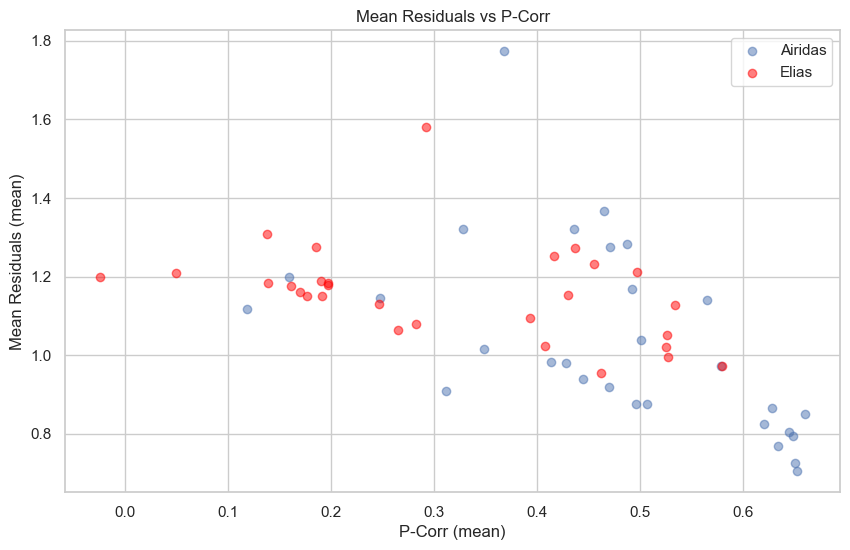

In [108]:
import matplotlib.pyplot as plt

# Assuming 'mean_residual_Airidas_mean' and 'p-corr_Airidas_mean' are already computed as mean values in your aggregated dataframe
# Plotting for Airidas
plt.figure(figsize=(10, 6))
plt.scatter(dfg['p-corr_Airidas_mean'], dfg['mean_residual_Airidas_mean'], label='Airidas', alpha=0.5)

# Assuming 'mean_residual_Elias_mean' and 'p-corr_Elias_mean' are also computed as mean values
# Plotting for Elias
plt.scatter(dfg['p-corr_Elias_mean'], dfg['mean_residual_Elias_mean'], color='red', label='Elias', alpha=0.5)

plt.title('Mean Residuals vs P-Corr')
plt.xlabel('P-Corr (mean)')
plt.ylabel('Mean Residuals (mean)')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\Abrikosas\AppData\Local\Temp\ipykernel_10040\108790087.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sorted_airidas_personality, y='sim_signature', x='p-corr_Airidas_mean', ax=axs[0, 0], palette=colors_airidas_p, orient='h')
C:\Users\Abrikosas\AppData\Local\Temp\ipykernel_10040\108790087.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sorted_airidas_kano, y='sim_signature', x='p-corr_Airidas_mean', ax=axs[1, 0], palette=colors_airidas_k, orient='h')
C:\Users\Abrikosas\AppData\Local\Temp\ipykernel_10040\108790087.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and 

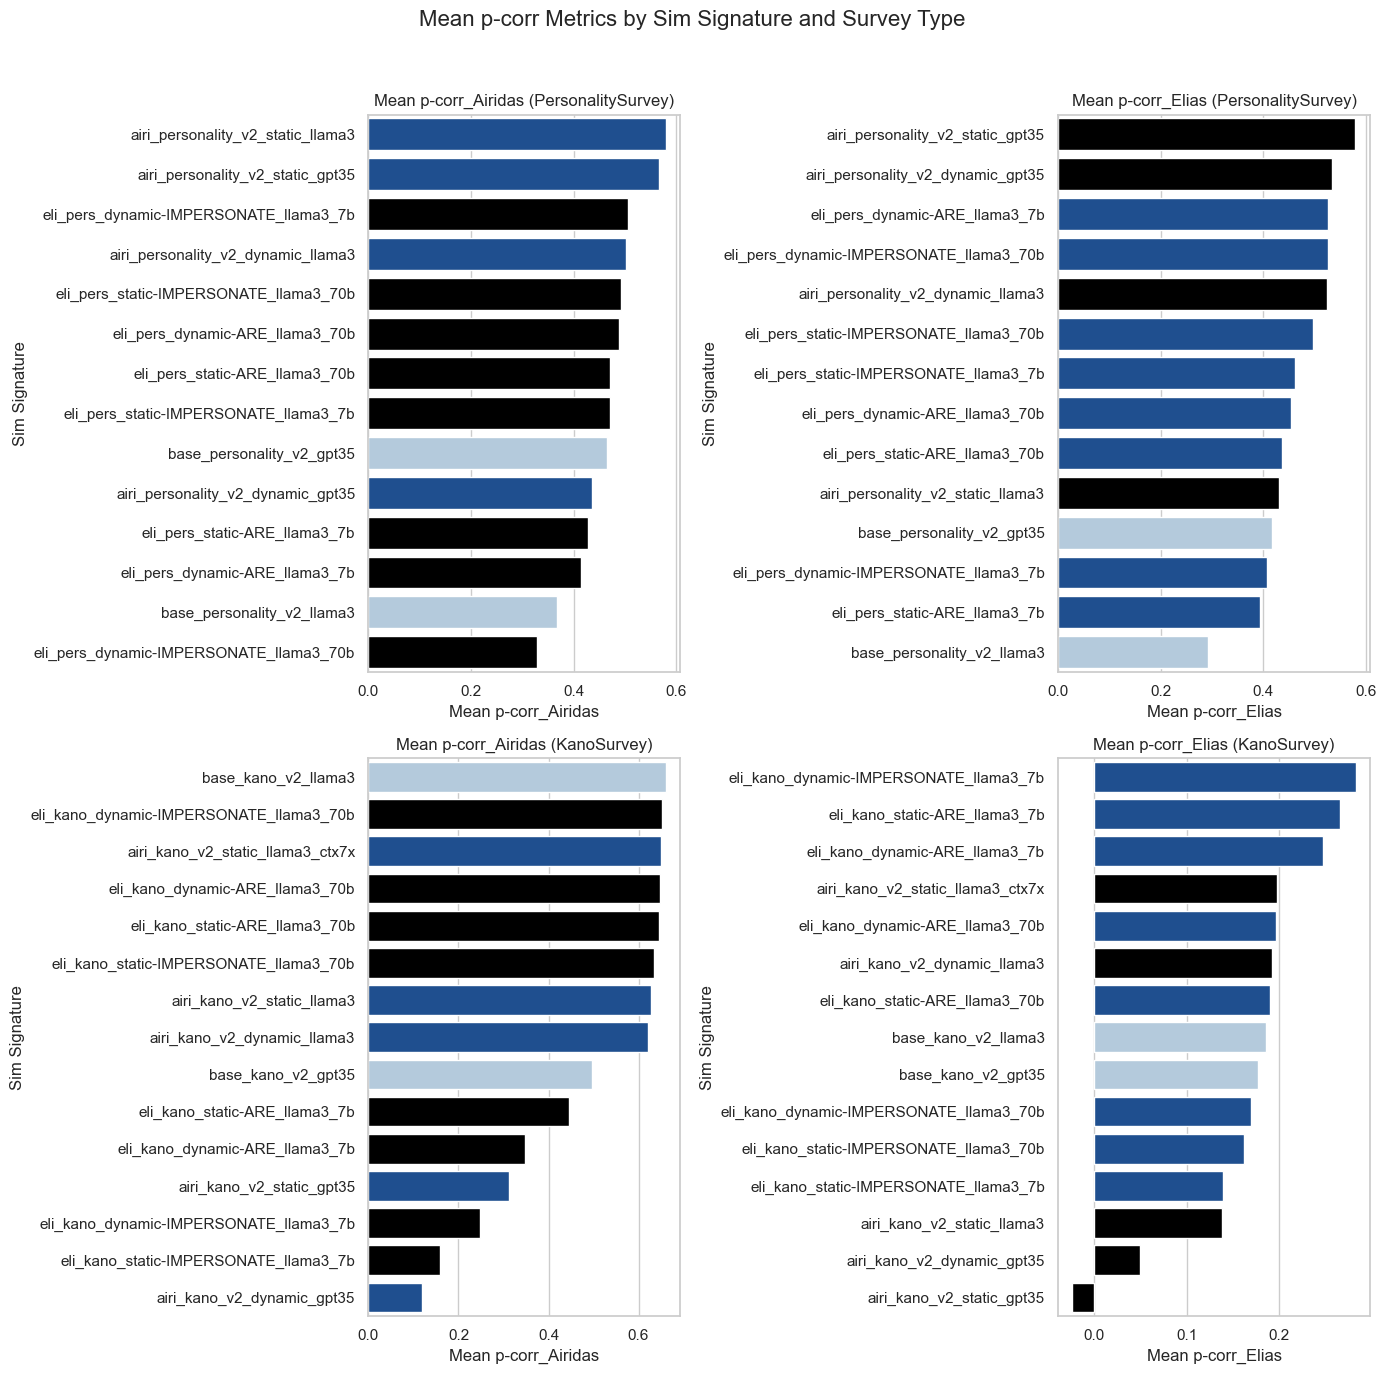

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set style
sns.set(style="whitegrid")

# Sorting and filtering the dataframe for each plot
sorted_airidas_personality = dfg[(dfg['survey_type'] == 'PersonalitySurvey')].sort_values('p-corr_Airidas_mean', ascending=False)
sorted_airidas_kano = dfg[(dfg['survey_type'] == 'KanoSurvey')].sort_values('p-corr_Airidas_mean', ascending=False)
sorted_elias_personality = dfg[(dfg['survey_type'] == 'PersonalitySurvey')].sort_values('p-corr_Elias_mean', ascending=False)
sorted_elias_kano = dfg[(dfg['survey_type'] == 'KanoSurvey')].sort_values('p-corr_Elias_mean', ascending=False)

# Custom color function that also compares the 'SUBJECT' value
def get_colors_airidas(df):
    colors = []
    for _, row in df.iterrows():
        if row['SUBJECT'] != 'airidas' and not row['is_base']:
            colors.append('black')  # Color these bars black if 'SUBJECT' is not 'airidas'
        elif row['is_base']:
            colors.append('#adcbe3')  # Soft tinted light blue
        else:
            colors.append('#0c4da2')  # Deep blue

    return colors

def get_colors_elias(df):
    colors = []
    for _, row in df.iterrows():
        if row['SUBJECT'] != 'elias' and not row['is_base']:
            colors.append('black')  # Color these bars black if 'SUBJECT' is not 'elias'
        elif row['is_base']:
            colors.append('#adcbe3')  # Soft tinted light blue
        else:
            colors.append('#0c4da2')  # Deep blue

    return colors

# Get colors for each dataset
colors_airidas_p = get_colors_airidas(sorted_airidas_personality)
colors_airidas_k = get_colors_airidas(sorted_airidas_kano)
colors_elias_p = get_colors_elias(sorted_elias_personality)
colors_elias_k = get_colors_elias(sorted_elias_kano)

# Create a figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 14))  # 2 rows, 2 columns
fig.suptitle('Mean p-corr Metrics by Sim Signature and Survey Type', fontsize=16)

# Plotting as horizontal bar charts using sorted data and custom colors
sns.barplot(data=sorted_airidas_personality, y='sim_signature', x='p-corr_Airidas_mean', ax=axs[0, 0], palette=colors_airidas_p, orient='h')
axs[0, 0].set_title('Mean p-corr_Airidas (PersonalitySurvey)')
axs[0, 0].set_xlabel('Mean p-corr_Airidas')
axs[0, 0].set_ylabel('Sim Signature')

sns.barplot(data=sorted_airidas_kano, y='sim_signature', x='p-corr_Airidas_mean', ax=axs[1, 0], palette=colors_airidas_k, orient='h')
axs[1, 0].set_title('Mean p-corr_Airidas (KanoSurvey)')
axs[1, 0].set_xlabel('Mean p-corr_Airidas')
axs[1, 0].set_ylabel('Sim Signature')

sns.barplot(data=sorted_elias_personality, y='sim_signature', x='p-corr_Elias_mean', ax=axs[0, 1], palette=colors_elias_p, orient='h')
axs[0, 1].set_title('Mean p-corr_Elias (PersonalitySurvey)')
axs[0, 1].set_xlabel('Mean p-corr_Elias')
axs[0, 1].set_ylabel('Sim Signature')

sns.barplot(data=sorted_elias_kano, y='sim_signature', x='p-corr_Elias_mean', ax=axs[1, 1], palette=colors_elias_k, orient='h')
axs[1, 1].set_title('Mean p-corr_Elias (KanoSurvey)')
axs[1, 1].set_xlabel('Mean p-corr_Elias')
axs[1, 1].set_ylabel('Sim Signature')

# Adjust layout for readability
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show plot
plt.show()